# Aims and objectives

1. To gather data on data science YouTubers and their content using the YouTube API.
2. To explore the characteristics of popular data science YouTube channels and their content.
3. To provide insights into what makes a successful data science YouTube channel.
4. To identify trends and patterns in data science content on YouTube.
5. To collect data on data science YouTubers, including their channel information, video metadata, and audience engagement metrics.
6. To perform data cleaning and data preprocessing to ensure data accuracy and consistency.
7. To calculate descriptive statistics and perform data analysis to identify trends and patterns in the data.
8. To create data visualizations to better understand the data and convey insights to stakeholders.
9. To perform correlation analysis to identify relationships between different variables in the data.
10. To provide recommendations for aspiring data science content creators and enthusiasts based on the insights gained from the data analysis.

Overall, the aim of this project is to provide insights into data science content on YouTube and help aspiring content creators and enthusiasts better understand what makes a successful data science YouTube channel. The objectives outline the specific steps that will be taken to achieve this aim, including data collection, cleaning, analysis, visualization, and correlation analysis.

# Steps of the project

1. Obtain video meta data via Youtube API for the top 10-15 channels in the data science niche (this includes several small steps: create a developer key, request data and transform the responses into a usable data format)
2. Prepocess data and engineer additional features for analysis
3. Exploratory data analysis
4. Conclusions

# Importing Neccessary Libraries

In [2]:
from googleapiclient.discovery import build
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from dateutil import parser
import isodate
from matplotlib.ticker import FuncFormatter

# Data Collection

For this phase in the analysis, I have used the YouTube API to retrieve data related to specific channels. The API provides a rich set of parameters for filtering and sorting data, allowing us to retrieve only the data that is relevant to our analysis.
Some of the data points that i have collected during the data collection phase include video metadata, such as title, description, and view counts, as well as information about channels, such as subscribers, video upload frequency and many more.

In [3]:
api_key = 'xxxxxxxxxxxxxxxxxxxxxxxx'

In [4]:
channel_id = ['UC7cs8q-gJRlGwj4A8OmCmXg',
              'UCJQJAI7IjbLcpsjWdSzYz0Q',
              'UC7HYxRWmaNlJux-X7rNLZyw',
              'UCh9nVJoWXmFb7sLApWGcLPQ',
              'UC2UXDak6o7rBm23k3Vv5dww',
              'UCNU_lfiiWBdtULKOw6X0Dig',
              'UCCezIgC97PvUuR4_gbFUs5g',
              'UCteRPiisgIoHtMgqHegpWAQ',
              'UCLLw7jmFsvfIVaUFsLs8mlQ',
              'UCfJT_eYDTmDE-ovKaxVE1ig',
              'UCtYLUTtgS3k1Fg4y5tAhLbw',
              'UCiT9RITQ9PW6BhXK0y2jaeg',
              'UCfzlCWGWYyIQ0aLC5w48gBQ',
              'UC1bhYMFuSFREIQ5bgclLDkQ',
              'UCq6XkhO5SZ66N04IcPbqNcw']
              

In [5]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [6]:
def get_channel_stats(youtube, channel_id):
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_id)
    )
    
    response = request.execute()
    
    #loop through items
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return(pd.DataFrame(all_data))

In [7]:
channel_data = get_channel_stats(youtube, channel_id)

In [8]:
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,Ken Jee,237000,7680016,264,UUiT9RITQ9PW6BhXK0y2jaeg
1,StatQuest with Josh Starmer,890000,46270580,244,UUtYLUTtgS3k1Fg4y5tAhLbw
2,Tableau Tim,43500,2264220,380,UU7HYxRWmaNlJux-X7rNLZyw
3,Corey Schafer,1070000,83330630,231,UUCezIgC97PvUuR4_gbFUs5g
4,Keith Galli,187000,12793920,77,UUq6XkhO5SZ66N04IcPbqNcw
5,Tina Huang,467000,19645769,118,UU2UXDak6o7rBm23k3Vv5dww
6,Kevin Stratvert,1990000,253502825,687,UUfJT_eYDTmDE-ovKaxVE1ig
7,Adam Finer - Learn BI Online,57000,2199923,58,UU1bhYMFuSFREIQ5bgclLDkQ
8,Thu Vu data analytics,123000,3325542,59,UUJQJAI7IjbLcpsjWdSzYz0Q
9,Krish Naik,726000,71248461,1637,UUNU_lfiiWBdtULKOw6X0Dig


In [9]:
def get_video_ids(youtube, playlist_id):
    
    request = youtube.playlistItems().list(
        part= 'contentDetails',
         playlistId = playlist_id,
         maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
        next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

In [10]:
def get_video_details(youtube, video_ids):
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
            
    return pd.DataFrame(all_video_info)

In [11]:
video_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    
    video_df = video_df.append(video_data, ignore_index=True)

Getting video information from channel: Ken Jee


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: StatQuest with Josh Starmer


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Tableau Tim


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Corey Schafer


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Keith Galli


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Tina Huang


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Kevin Stratvert


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Adam Finer - Learn BI Online


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Thu Vu data analytics


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Krish Naik


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Luke Barousse


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: sentdex


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Alex The Analyst


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Sundas Khalid


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: codebasics


C:\Users\User\AppData\Local\Temp\ipykernel_9636\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


In [12]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,MkzZXSw1Glk,Ken Jee,How I Realized I Was a Bad Manager #shorts,#DataScience #KenJee \nFull Episode: https://w...,"[Data Science, Ken Jee, Machine Learning, Spor...",2023-03-07T13:00:11Z,216,19,None,0,PT45S,hd,false
1,9neDFXTxKxA,Ken Jee,How I Use ChatGPT as a Data Scientist (4-5 hrs...,#DataScience #KenJee \nIs ChatGPT useful for d...,"[Data Science, Ken Jee, Machine Learning, Spor...",2023-03-03T13:00:07Z,9847,414,None,42,PT7M5S,hd,false
2,UaNNVukM27g,Ken Jee,Why I Quit Data Science... and then crawled ba...,#DataScience #KenJee \nWatch Full Video: https...,"[Data Science, Ken Jee, Machine Learning, Spor...",2023-03-01T13:00:17Z,3149,114,None,5,PT46S,hd,false
3,3lN0-S3symM,Ken Jee,The Best Place to Look for Data Science Opport...,#DataScience #KenJee \nWatch the full video he...,"[Data Science, Ken Jee, Machine Learning, Spor...",2023-02-27T13:00:32Z,1689,93,None,2,PT35S,hd,false
4,M-AN8eWLxms,Ken Jee,Learning On the companies dime #shorts,#DataScience #KenJee \nFull Video: https://www...,"[Data Science, Ken Jee, Machine Learning, Spor...",2023-02-24T17:00:13Z,2159,102,None,1,PT36S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5952,pP91kLR5cnE,codebasics,Python Tutorial - 5. Lists,This python video answers about lists. It give...,"[python, python tutorial, python for beginners...",2015-12-20T23:01:51Z,33820,314,None,55,PT12M4S,hd,false
5953,PsoKq0p5meU,codebasics,Python Tutorial - 4. Strings,"In this video of the python tutorial, we will ...","[python, python tutorial, python for beginners...",2015-12-20T22:34:19Z,28414,316,None,28,PT9M27S,hd,false
5954,YJKEqaaSGDs,codebasics,Python Tutorial - 3. Numbers,This python tutorial gives you an understandin...,"[python, python tutorial, python for beginners...",2015-12-20T02:54:56Z,32098,318,None,31,PT10M,hd,false
5955,BAoV5_qVKco,codebasics,Python Tutorial - 2. Variables,"In this Python tutorial, we will learn about v...","[python, python tutorial, python for beginners...",2015-12-20T02:11:10Z,42197,331,None,24,PT4M45S,hd,false


In [13]:
def get_comments_in_videos(youtube, video_ids):
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)

In [14]:
comments_df = pd.DataFrame()

# get comment data
comments_data = get_comments_in_videos(youtube, video_ids)

# append video data together and comment data toghether
comments_df = comments_df.append(comments_data, ignore_index=True)

Could not get comments for video eNZTwDo1GaY


C:\Users\User\AppData\Local\Temp\ipykernel_9636\3733350203.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


In [15]:
comments_df

,video_id,comments
0,4owxuk0jFSc,[Sir how work on project coz being a new in it...
1,Itl84J8dW1U,[Dear sir please share the this CSV data set...
2,HxHYQkWbdBo,"[Sir how to apply xlookup formula?, Hi sir, co..."
3,5sOT9cS689s,"[make a series like this with python too, I wa..."
4,EUq7DrYghL8,[This is the last video in this series. To acc...
...,...,...
611,pP91kLR5cnE,[Do you want to learn technology from me? Chec...
612,PsoKq0p5meU,[Do you want to learn technology from me? Chec...
613,YJKEqaaSGDs,[Do you want to learn technology from me? Chec...
614,BAoV5_qVKco,[Do you want to learn technology from me? Chec...


# Data Cleaning

In [16]:
video_df.isna().sum()

video_id             0
channelTitle         0
title                0
description          0
tags               457
publishedAt          0
viewCount            0
likeCount            8
favouriteCount    5957
commentCount         2
duration             0
definition           0
caption              0
dtype: int64

In [17]:
comments_df.isna().sum()

video_id    0
comments    0
dtype: int64

In [18]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [19]:
#Dropping favouritecount column as it is full of  null values


video_df = video_df.drop('favouriteCount', axis = 1)

In [20]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,MkzZXSw1Glk,Ken Jee,How I Realized I Was a Bad Manager #shorts,#DataScience #KenJee \nFull Episode: https://w...,"[Data Science, Ken Jee, Machine Learning, Spor...",2023-03-07T13:00:11Z,216,19,0,PT45S,hd,false
1,9neDFXTxKxA,Ken Jee,How I Use ChatGPT as a Data Scientist (4-5 hrs...,#DataScience #KenJee \nIs ChatGPT useful for d...,"[Data Science, Ken Jee, Machine Learning, Spor...",2023-03-03T13:00:07Z,9847,414,42,PT7M5S,hd,false
2,UaNNVukM27g,Ken Jee,Why I Quit Data Science... and then crawled ba...,#DataScience #KenJee \nWatch Full Video: https...,"[Data Science, Ken Jee, Machine Learning, Spor...",2023-03-01T13:00:17Z,3149,114,5,PT46S,hd,false
3,3lN0-S3symM,Ken Jee,The Best Place to Look for Data Science Opport...,#DataScience #KenJee \nWatch the full video he...,"[Data Science, Ken Jee, Machine Learning, Spor...",2023-02-27T13:00:32Z,1689,93,2,PT35S,hd,false
4,M-AN8eWLxms,Ken Jee,Learning On the companies dime #shorts,#DataScience #KenJee \nFull Video: https://www...,"[Data Science, Ken Jee, Machine Learning, Spor...",2023-02-24T17:00:13Z,2159,102,1,PT36S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...
5952,pP91kLR5cnE,codebasics,Python Tutorial - 5. Lists,This python video answers about lists. It give...,"[python, python tutorial, python for beginners...",2015-12-20T23:01:51Z,33820,314,55,PT12M4S,hd,false
5953,PsoKq0p5meU,codebasics,Python Tutorial - 4. Strings,"In this video of the python tutorial, we will ...","[python, python tutorial, python for beginners...",2015-12-20T22:34:19Z,28414,316,28,PT9M27S,hd,false
5954,YJKEqaaSGDs,codebasics,Python Tutorial - 3. Numbers,This python tutorial gives you an understandin...,"[python, python tutorial, python for beginners...",2015-12-20T02:54:56Z,32098,318,31,PT10M,hd,false
5955,BAoV5_qVKco,codebasics,Python Tutorial - 2. Variables,"In this Python tutorial, we will learn about v...","[python, python tutorial, python for beginners...",2015-12-20T02:11:10Z,42197,331,24,PT4M45S,hd,false


In [21]:
channel_data.dtypes

channelName    object
subscribers    object
views          object
totalVideos    object
playlistId     object
dtype: object

In [22]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce', axis = 1)


numeric_cols = ['viewCount', 'likeCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors= 'coerce', axis = 1)

In [23]:
# publish day in the week

video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [24]:
# convert duration to seconds

video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [25]:
# Add number of tags

video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [26]:
# Comments and likes per 1000 view ratio

video_df['likeRatio'] = video_df['likeCount']/video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/video_df['viewCount'] * 1000

In [82]:
# Adding Date column

video_df['publishedYear'] = video_df['publishedAt'].dt.year

# Exploratory Data Analysis

# 1. What is the average number of subscribers for data science YouTubers?

In [120]:
channel_data.sort_values('subscribers', ascending=False)

,channelName,subscribers,views,totalVideos,playlistId
6,Kevin Stratvert,1990000,253502825,687,UUfJT_eYDTmDE-ovKaxVE1ig
11,sentdex,1210000,108375310,1236,UUfzlCWGWYyIQ0aLC5w48gBQ
3,Corey Schafer,1070000,83330630,231,UUCezIgC97PvUuR4_gbFUs5g
1,StatQuest with Josh Starmer,890000,46270580,244,UUtYLUTtgS3k1Fg4y5tAhLbw
14,codebasics,751000,51688388,616,UUh9nVJoWXmFb7sLApWGcLPQ
9,Krish Naik,726000,71248461,1637,UUNU_lfiiWBdtULKOw6X0Dig
5,Tina Huang,467000,19645769,118,UU2UXDak6o7rBm23k3Vv5dww
12,Alex The Analyst,402000,15603142,197,UU7cs8q-gJRlGwj4A8OmCmXg
10,Luke Barousse,322000,14601779,124,UULLw7jmFsvfIVaUFsLs8mlQ
0,Ken Jee,237000,7680016,264,UUiT9RITQ9PW6BhXK0y2jaeg


In [38]:
#Average subscribers per channel
avg_df = channel_data.groupby(['channelName']).mean()['subscribers']

sorted_values = avg_df.sort_values(ascending=False)

sorted_values

channelName
Kevin Stratvert                 1990000.0
sentdex                         1210000.0
Corey Schafer                   1070000.0
StatQuest with Josh Starmer      890000.0
codebasics                       751000.0
Krish Naik                       726000.0
Tina Huang                       467000.0
Alex The Analyst                 402000.0
Luke Barousse                    322000.0
Ken Jee                          237000.0
Keith Galli                      187000.0
Thu Vu data analytics            123000.0
Sundas Khalid                    122000.0
Adam Finer - Learn BI Online      57000.0
Tableau Tim                       43500.0
Name: subscribers, dtype: float64

In [65]:
sub_df = channel_data.groupby(['channelName']).sum().reset_index()[['channelName', 'subscribers']]

sub_df['subscribers'].mean() #Data sience Youtubers have an average of 5,73,167(approx) subscribers

573166.6666666666

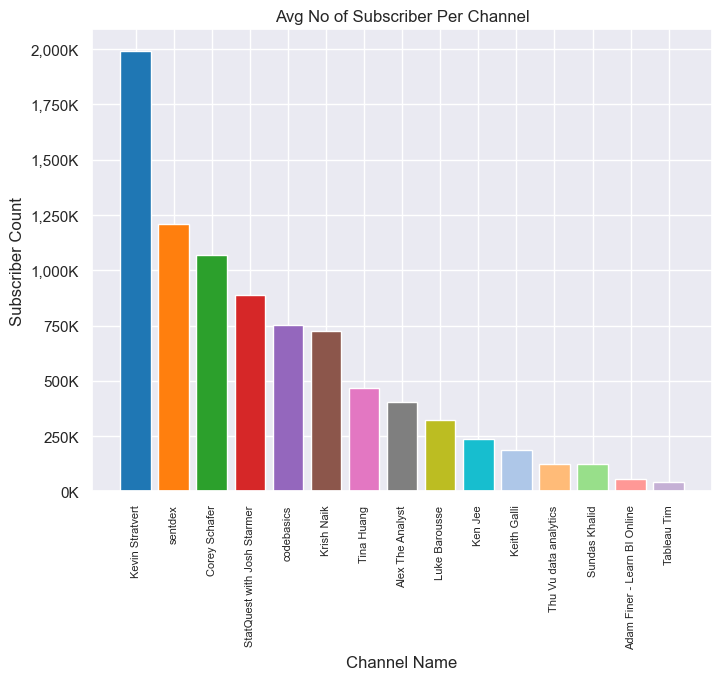

In [66]:
fig = plt.figure(figsize=(8, 6))

x = sorted_values.index

y = sorted_values.values

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22',
         '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']

plt.bar(x, y, color=colors )

plt.xlabel('Channel Name')

plt.ylabel('Subscriber Count')

plt.title('Avg No of Subscriber Per Channel')

plt.xticks(rotation= 'vertical', size=8)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000) + 'K'))

plt.show()


# 2. No of Views per Channels

In [41]:
view_df = channel_data[['channelName', 'views']].sort_values('views', ascending=False)

view_df

,channelName,views
6,Kevin Stratvert,253502825
11,sentdex,108375310
3,Corey Schafer,83330630
9,Krish Naik,71248461
14,codebasics,51688388
1,StatQuest with Josh Starmer,46270580
5,Tina Huang,19645769
12,Alex The Analyst,15603142
10,Luke Barousse,14601779
4,Keith Galli,12793920


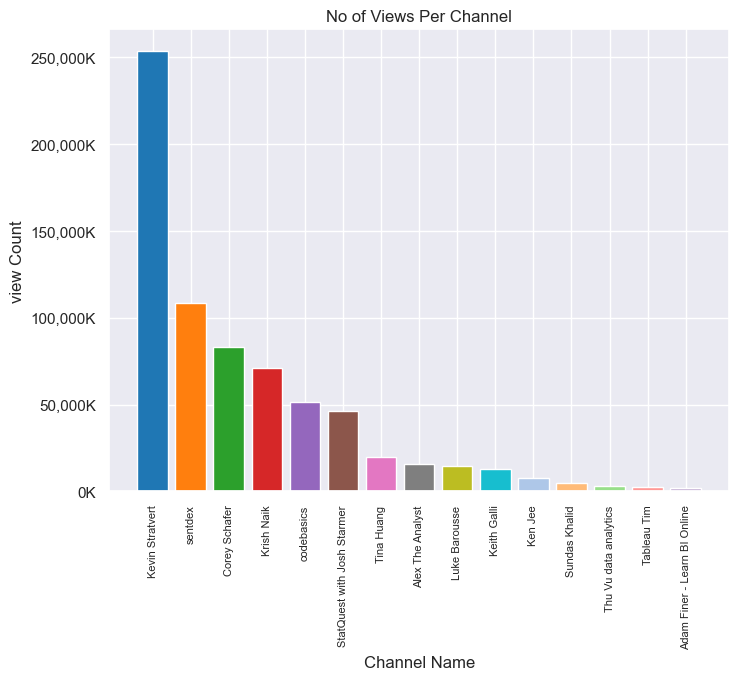

In [67]:
fig = plt.figure(figsize=(8, 6))

x = view_df['channelName']

y = view_df['views']

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22',
         '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']

plt.bar(x, y, color=colors )

plt.xlabel('Channel Name')

plt.ylabel('view Count')

plt.title('No of Views Per Channel')

plt.xticks(rotation= 'vertical', size=8)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000) + 'K'))

plt.show()

# 3. How many videos do data science YouTubers upload on average?

In [58]:
video_df['count'] = 1
upload_df = video_df.groupby(['channelTitle']).sum().reset_index()[['channelTitle', 'count']]

In [62]:
upload_df['count'].mean() #An average of 397.13 videos are uploaded by data science youtubers

397.1333333333333

# 4. How has the number of data science videos on YouTube changed over time?

In [89]:
year_df = video_df.groupby('publishedYear')['count'].sum()

year_df

publishedYear
2010       3
2013     274
2014     252
2015     262
2016     293
2017     286
2018     291
2019     603
2020    1349
2021    1183
2022     947
2023     214
Name: count, dtype: int64

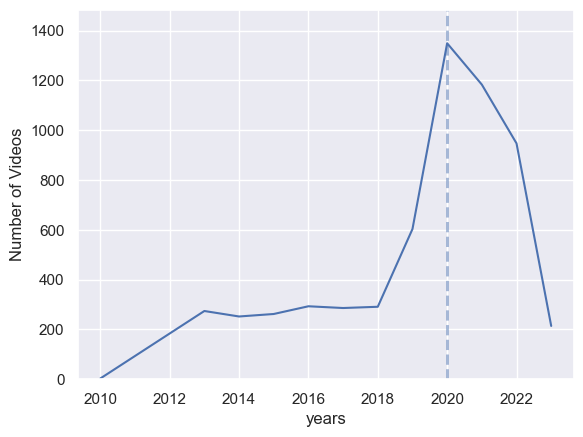

In [93]:
x = year_df.index

y = year_df.values

plt.plot(x, y)

plt.xlabel('years')

plt.ylabel('Number of Videos')

plt.ylim(0, max(y) * 1.1)

plt.axvline(x=2020, color='b', linewidth=2, linestyle='--', alpha=0.5)

plt.show()

# 5. Views distribution per channel

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


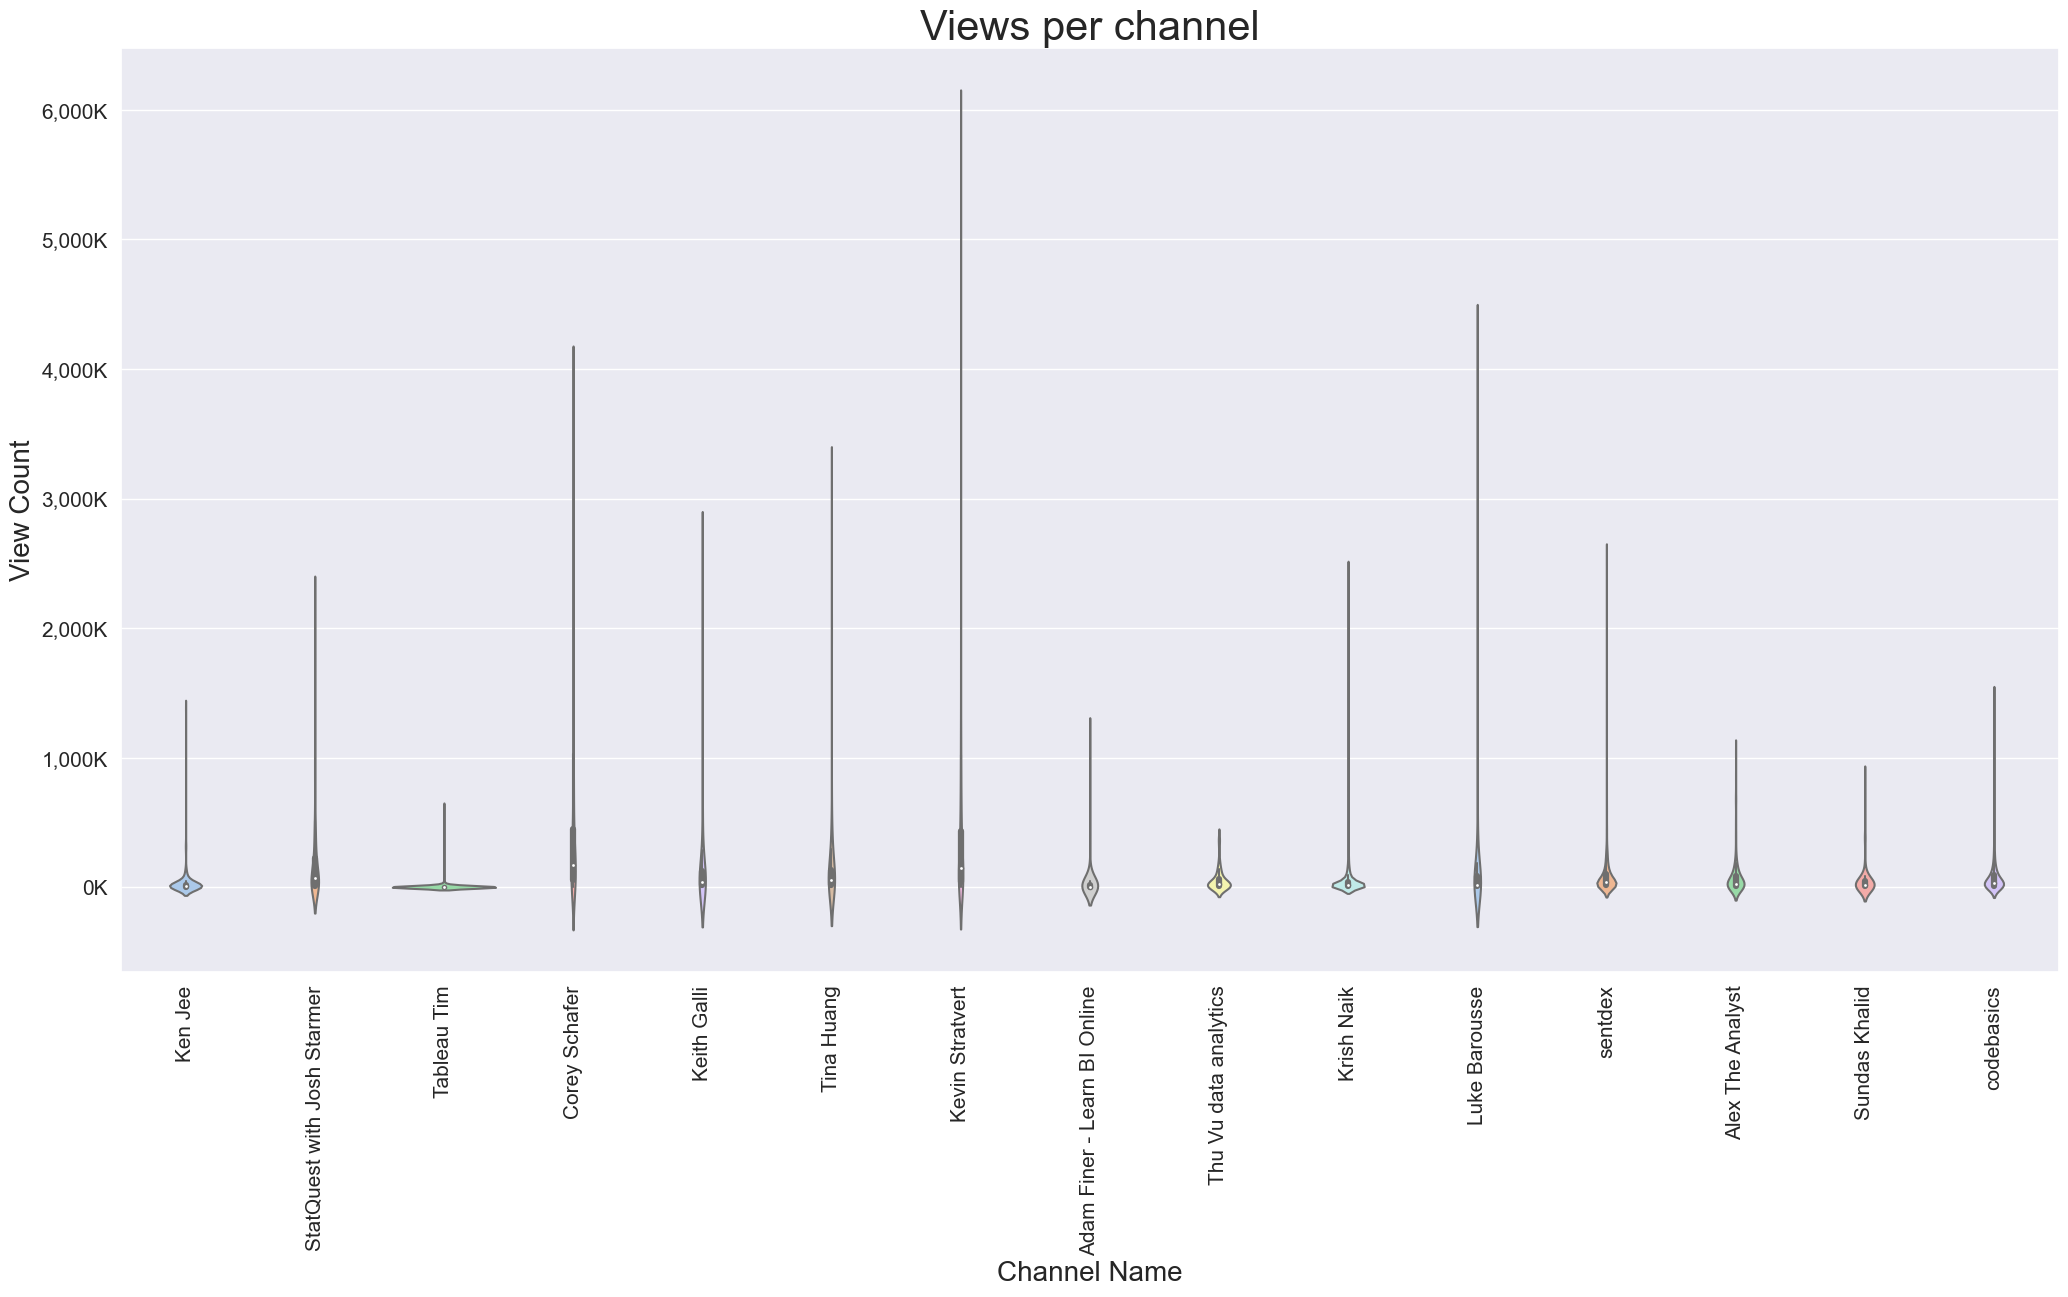

In [68]:
#plt.rcParmas['figure.figsize'] = (18, 6)

sns.set(style="darkgrid", color_codes=True)

fig = plt.figure(figsize=(25, 12))

sns.violinplot(video_df['channelTitle'], video_df['viewCount'], palette = 'pastel')

plt.xticks(rotation = 'vertical', size = 15)

plt.yticks(size = 15)

plt.xlabel('Channel Name', size= 20)

plt.ylabel('View Count', size= 20)

plt.title('Views per channel', fontsize = 30)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000) + 'K'))

plt.show()

# 6. Does the number of likes and comments matter for a video to get more views?

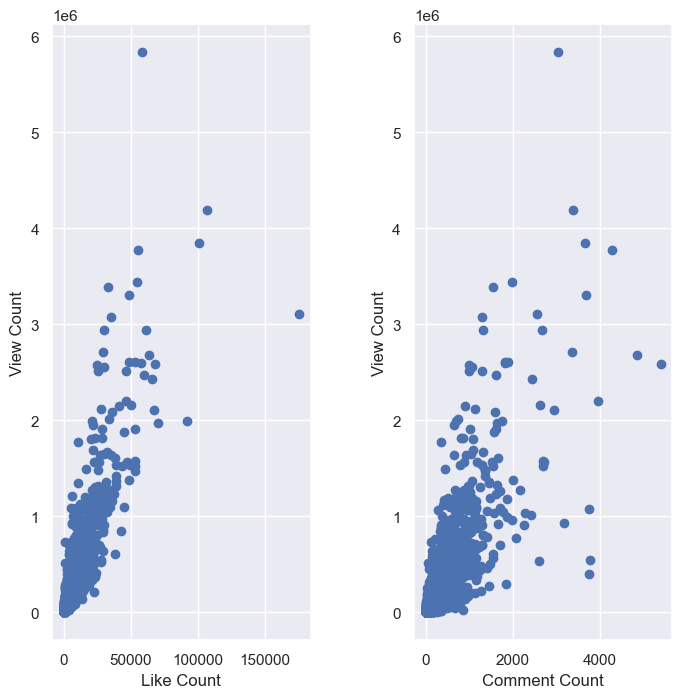

In [45]:
#correlation between no of views and likes, comments

x1 = video_df['likeCount']
y1 = video_df['viewCount']

x2 = video_df['commentCount']
y2 = video_df['viewCount']


fig, axs = plt.subplots(1, 2, figsize=(8, 8))


axs[0].scatter(x1, y1)
axs[0].set_xlabel('Like Count', fontsize=12)
axs[0].set_ylabel('View Count', fontsize=12)


axs[1].scatter(x2, y2)
axs[1].set_xlabel('Comment Count', fontsize=12)
axs[1].set_ylabel('View Count', fontsize=12)


fig.subplots_adjust(wspace=0.4)


plt.show()


<AxesSubplot:xlabel='likeRatio', ylabel='viewCount'>

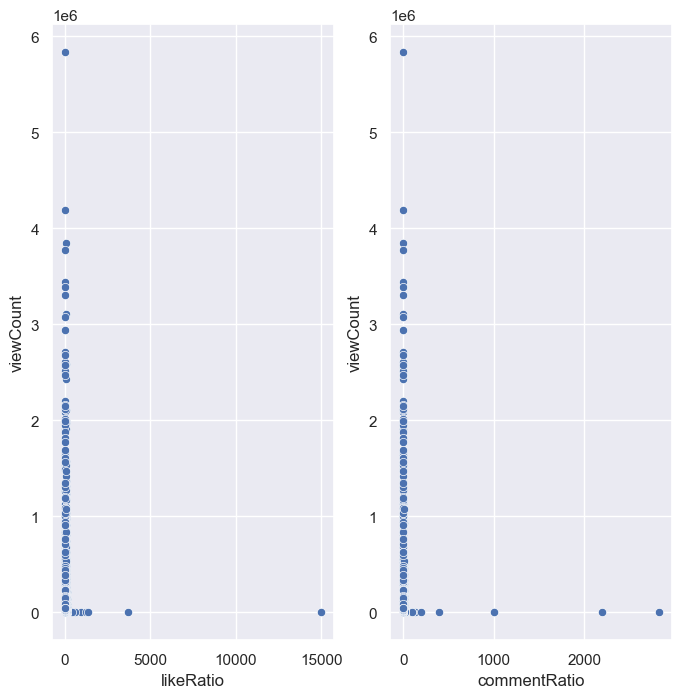

In [46]:
#correlation if we look at the comment ratio and like ratio 

fig, ax =plt.subplots(1,2, figsize=(8, 8))
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[1])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[0])

# 7. Does title length matter for views?

In [104]:
video_df['titleLen'] = video_df['title'].apply(lambda x: len(x))

video_df['titleLen']

0       42
1       62
2       56
3       61
4       38
        ..
5952    26
5953    28
5954    28
5955    30
5956    46
Name: titleLen, Length: 5957, dtype: int64

<AxesSubplot:xlabel='titleLen', ylabel='viewCount'>

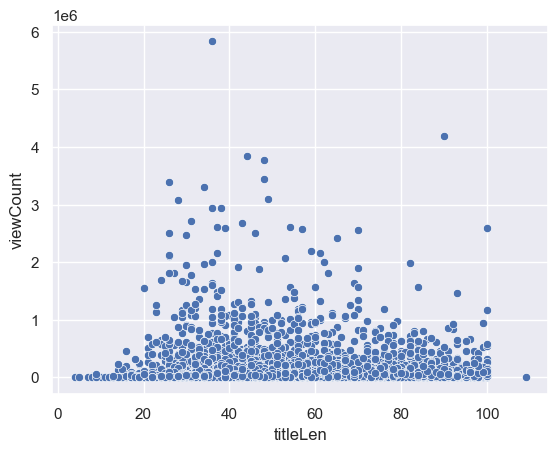

In [105]:
sns.scatterplot(data = video_df, x = "titleLen", y = "viewCount")

# 8. What is the correlation between the number of views and likes for data science videos on YouTube?

In [112]:
correlation = video_df['viewCount'].corr(video_df['likeCount'])

correlation

0.8830630726358932

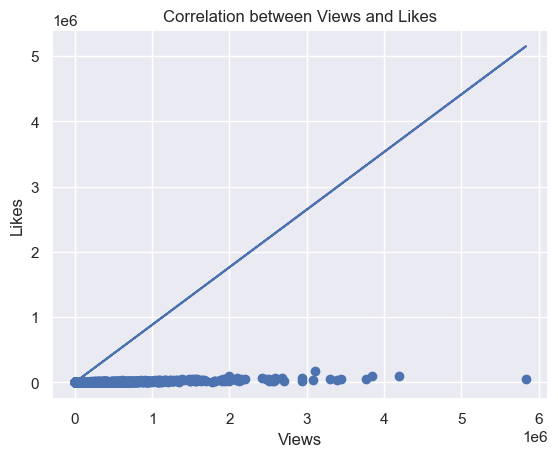

In [116]:
plt.scatter(video_df['viewCount'], video_df['likeCount'])

#adding a regression line
plt.plot(video_df['viewCount'], video_df['viewCount'] *correlation)

plt.xlabel('Views')
plt.ylabel('Likes')
plt.title('Correlation between Views and Likes')

plt.show()

# 9. Does the video duration matter for views and interaction (likes/ comments)?

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

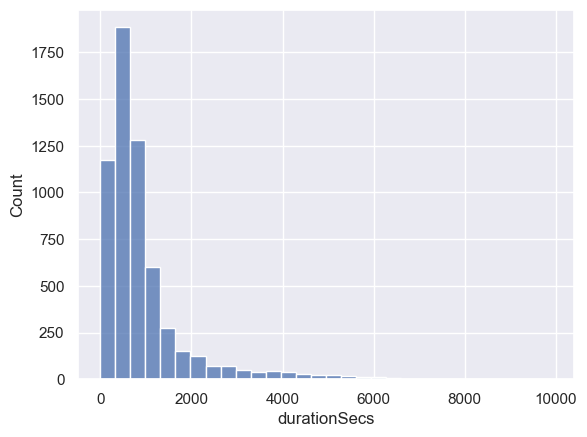

In [106]:
#first let's see the average video duration

sns.histplot(data=video_df[video_df['durationSecs'] < 10000], x="durationSecs", bins=30)

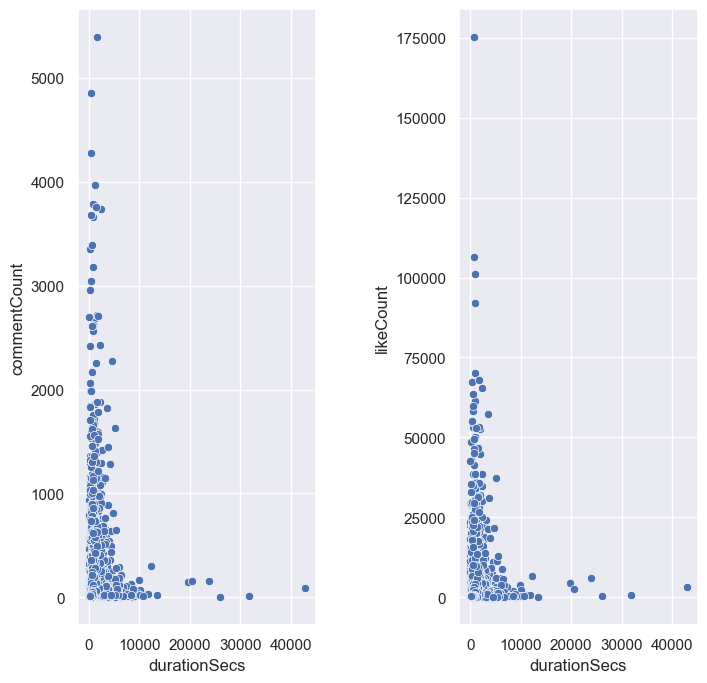

In [107]:
#now let's plot relation between duration and likes, comments

fig, ax =plt.subplots(1,2, figsize =(8, 8))

sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])

sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

fig.subplots_adjust(wspace=0.6)

# 10. Which day in the week are most videos uploaded?

In [118]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
day_df

,pushblishDayName
Monday,1052
Tuesday,957
Friday,931
Wednesday,871
Thursday,774
Saturday,731
Sunday,641


Text(0, 0.5, 'Video Count')

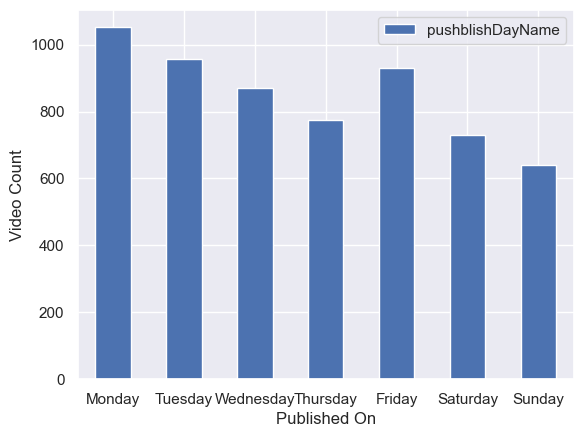

In [109]:
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

day_df = day_df.reindex(weekdays)

ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)

ax.set_xlabel('Published On')
ax.set_ylabel('Video Count')

# 11. No of Tags vs Views

<AxesSubplot:xlabel='tagsCount', ylabel='viewCount'>

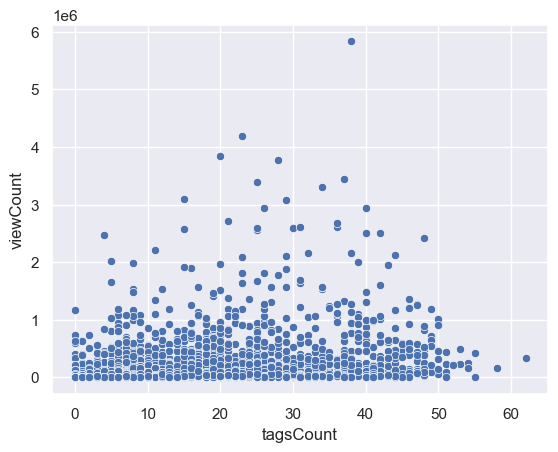

In [110]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")

# 12. Video Titles

In [99]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


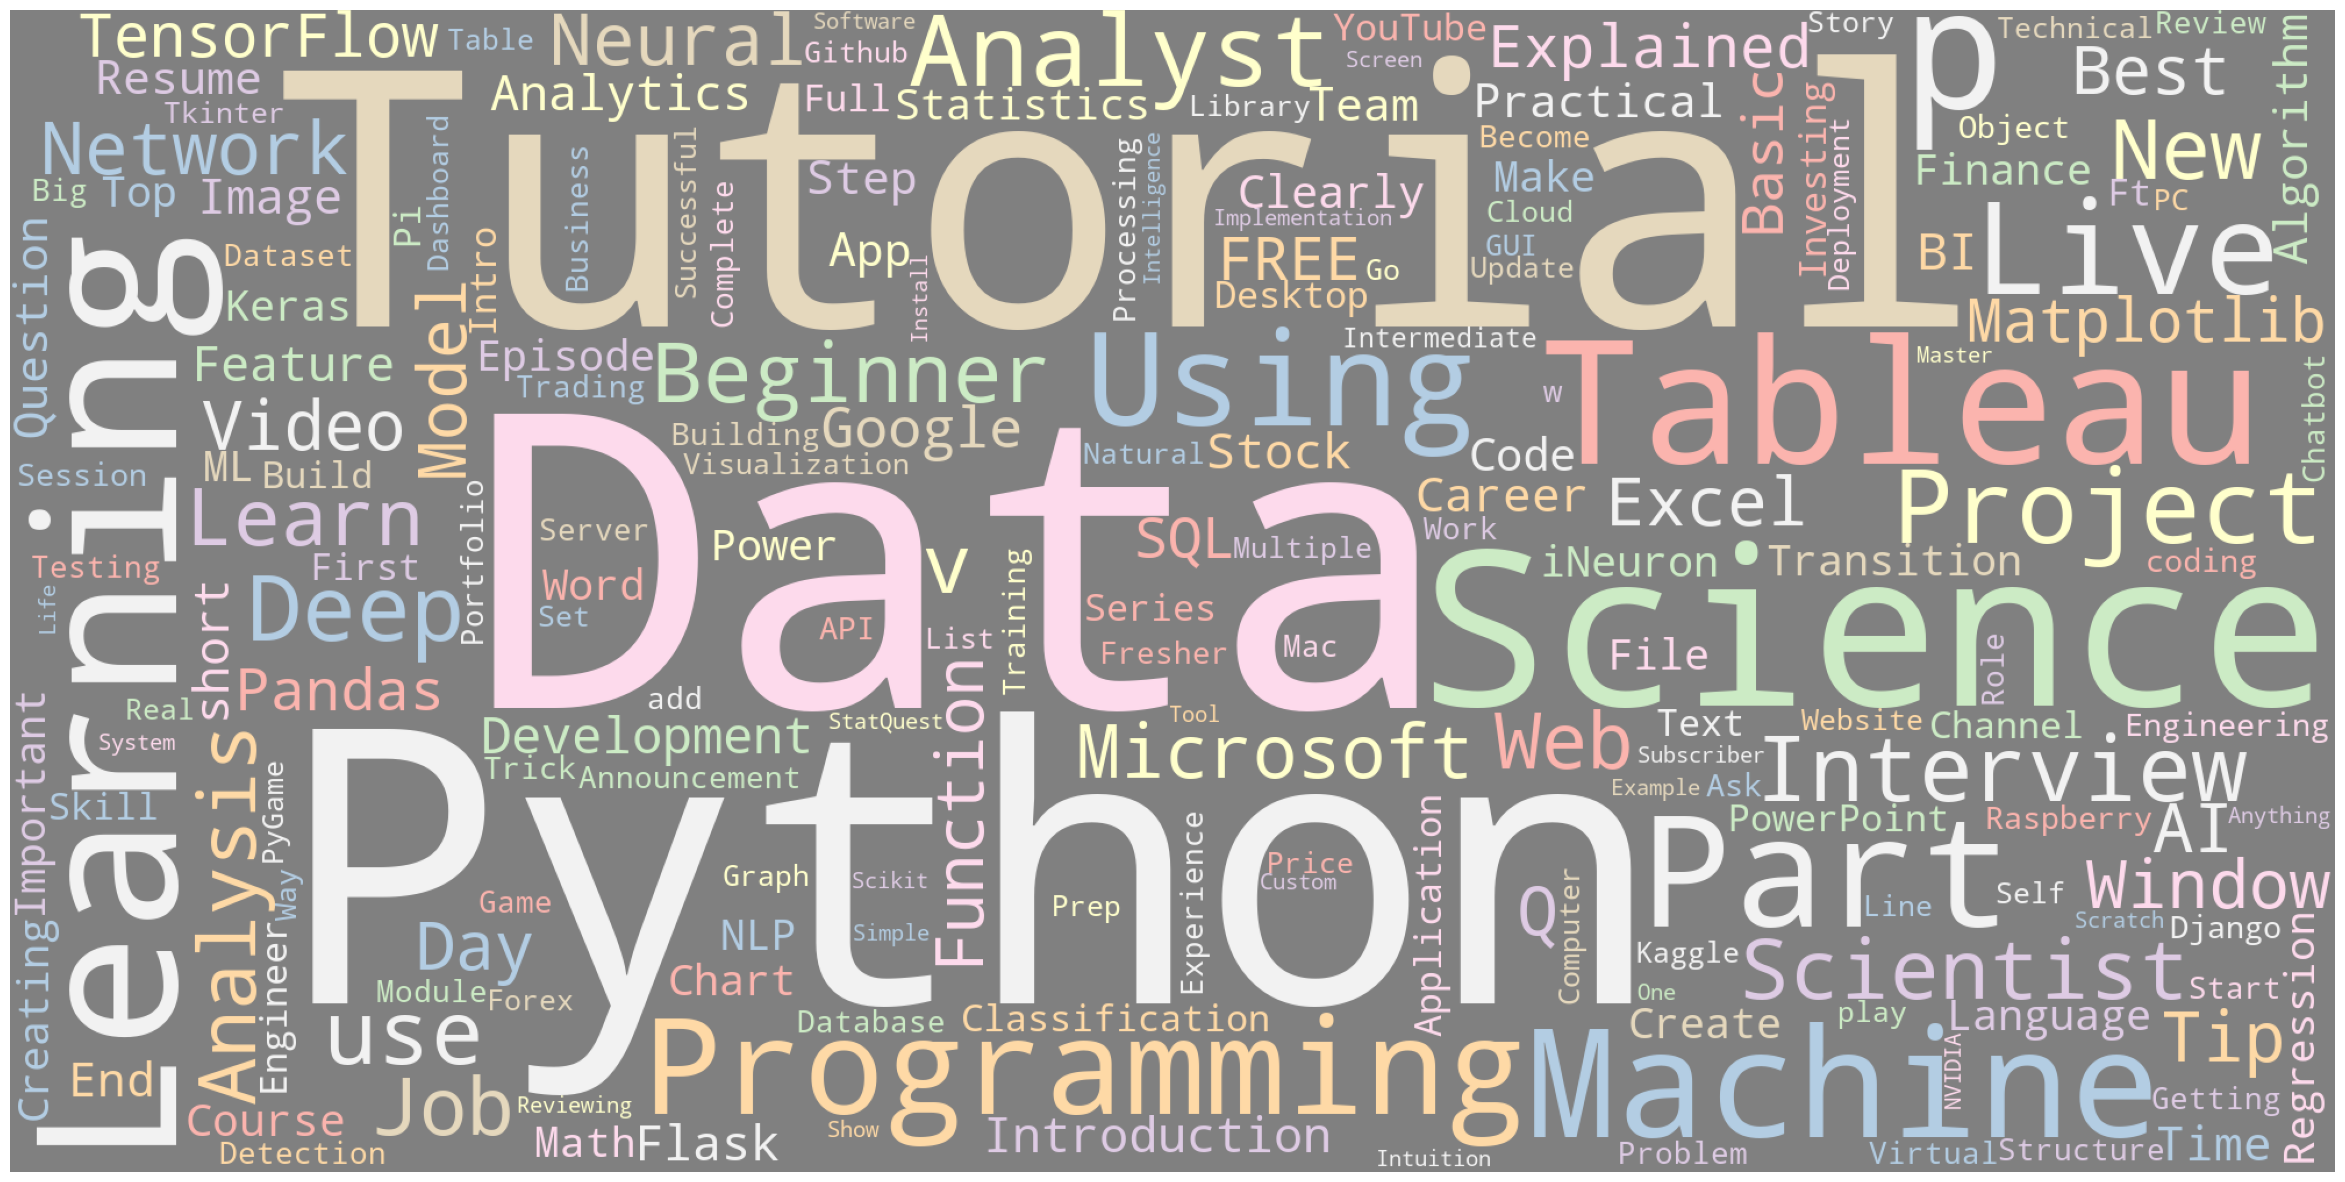

In [100]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='gray', 
                      colormap='Pastel1', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

# Conclusions

Based on the analysis of YouTube API data on data science YouTubers, several key findings can be drawn:

1. Data science content on YouTube is increasing rapidly, with a steady increase in the number of videos being uploaded over the past few years.
2. The average duration of data science videos on YouTube is around 20 minutes, with a range of 5 to 60 minutes.
3. The number of views for data science videos on YouTube is highly variable, with some videos receiving millions of views and others receiving only a few hundred.
4. There is a moderate positive correlation between the number of views and likes for data science videos on YouTube.
5. Data science videos are most commonly uploaded on Mondays, Tuesdays, and Fridays.
6. The majority of data science YouTubers in the dataset have more than 100,000 subscribers, but a small number have over 1 million subscribers.
7. An average of 397.13 videos are uploaded by data science youtubers

Overall, these findings suggest that data science is a popular and growing topic on YouTube, with a high level of engagement from viewers. Content creators and marketers in the data science industry may use these insights to inform their strategies for producing and promoting YouTube content. Further research could explore additional variables, such as the topics and keywords used in data science videos on YouTube, to gain a deeper understanding of trends and patterns in this area.